# OFDM Simulation in Pytorch

In [1]:
import torch
import numpy as np

save_plots = True

In [9]:
import matplotlib.pyplot as plt
def visualize_constellation(pts, Qm):
    plt.scatter(pts.numpy().real, pts.numpy().imag)
    plt.title(f'Modulation Order {Qm} Constellation')
    plt.ylabel('Imaginary'); plt.xlabel('Real')
    plt.tight_layout(); 
    if save_plots:
        plt.savefig(f'./const.png')

## Create modulation mapping tables

Modulation mapping tables translate binary data sequences into complex symbols for transmission in digital communication systems. BPSK, QPSK, and 16-QAM, e.g. 64QAM, 256QAM 1024 QAM and so on

In [10]:
def mapping_table(Qm, plot=False):
        
    # Size of the constellation
    size = int(torch.sqrt(torch.tensor(2**Qm)))
    # The constellation
    a = torch.arange(size, dtype=torch.float32)
    # Shift the constellation to the center
    b = a - torch.mean(a)
    # Use broadcasting to create the complex constellation grid
    C = (b.unsqueeze(1) + 1j * b).flatten()
    # Normalize the constellation
    C /= torch.sqrt(torch.mean(torch.abs(C)**2))
    # Function to convert index to binary
    def index_to_binary(i, Qm):
        return tuple(map(int, '{:0{}b}'.format(int(i), Qm)))
    
    # Create the mapping dictionary
    mapping = {index_to_binary(i, Qm): val for i, val in enumerate(C)}
    
    # Create the demapping table
    demapping = {v: k for k, v in mapping.items()}

    if plot:
        visualize_constellation(C, Qm)    
    return mapping, demapping

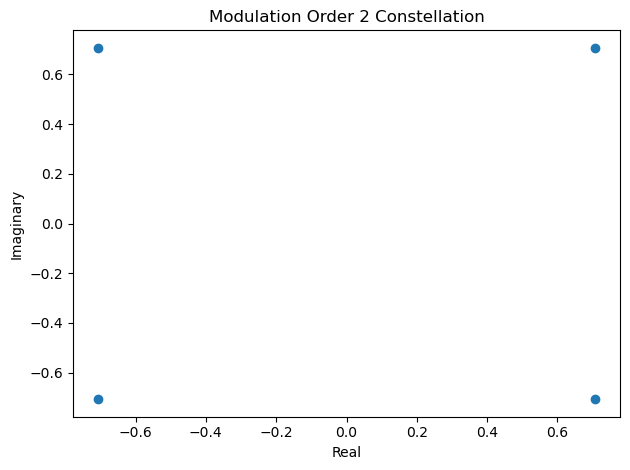

In [11]:
mapping_table_QPSK, de_mapping_table_QPSK = mapping_table(2, plot=True) # mapping table QPSK (e.g. for pilot symbols)

In [6]:
mapping_table_QPSK

{(0, 0): tensor(-0.7071-0.7071j),
 (0, 1): tensor(-0.7071+0.7071j),
 (1, 0): tensor(0.7071-0.7071j),
 (1, 1): tensor(0.7071+0.7071j)}

In [7]:
de_mapping_table_QPSK

{tensor(-0.7071-0.7071j): (0, 0),
 tensor(-0.7071+0.7071j): (0, 1),
 tensor(0.7071-0.7071j): (1, 0),
 tensor(0.7071+0.7071j): (1, 1)}

In [12]:
# OFDM Parameters
#Qm (int): Modulation order
Qm = 6  # bits per symbol

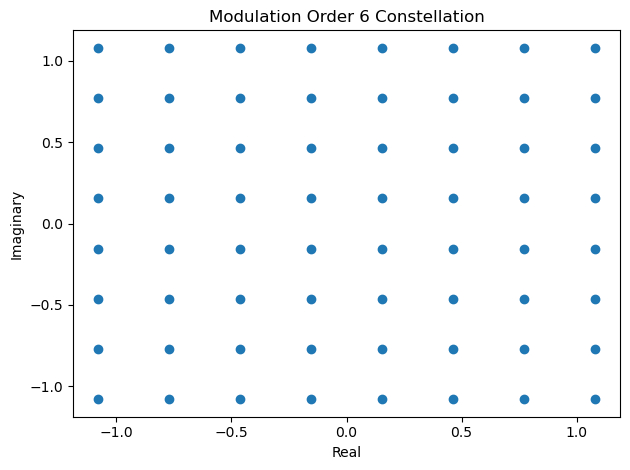

In [13]:
mapping_table_Qm, de_mapping_table_Qm = mapping_table(Qm, plot=True) # mapping table for Qm

In [17]:
mapping_table_Qm

{(0, 0, 0, 0, 0, 0): tensor(-1.0801-1.0801j),
 (0, 0, 0, 0, 0, 1): tensor(-1.0801-0.7715j),
 (0, 0, 0, 0, 1, 0): tensor(-1.0801-0.4629j),
 (0, 0, 0, 0, 1, 1): tensor(-1.0801-0.1543j),
 (0, 0, 0, 1, 0, 0): tensor(-1.0801+0.1543j),
 (0, 0, 0, 1, 0, 1): tensor(-1.0801+0.4629j),
 (0, 0, 0, 1, 1, 0): tensor(-1.0801+0.7715j),
 (0, 0, 0, 1, 1, 1): tensor(-1.0801+1.0801j),
 (0, 0, 1, 0, 0, 0): tensor(-0.7715-1.0801j),
 (0, 0, 1, 0, 0, 1): tensor(-0.7715-0.7715j),
 (0, 0, 1, 0, 1, 0): tensor(-0.7715-0.4629j),
 (0, 0, 1, 0, 1, 1): tensor(-0.7715-0.1543j),
 (0, 0, 1, 1, 0, 0): tensor(-0.7715+0.1543j),
 (0, 0, 1, 1, 0, 1): tensor(-0.7715+0.4629j),
 (0, 0, 1, 1, 1, 0): tensor(-0.7715+0.7715j),
 (0, 0, 1, 1, 1, 1): tensor(-0.7715+1.0801j),
 (0, 1, 0, 0, 0, 0): tensor(-0.4629-1.0801j),
 (0, 1, 0, 0, 0, 1): tensor(-0.4629-0.7715j),
 (0, 1, 0, 0, 1, 0): tensor(-0.4629-0.4629j),
 (0, 1, 0, 0, 1, 1): tensor(-0.4629-0.1543j),
 (0, 1, 0, 1, 0, 0): tensor(-0.4629+0.1543j),
 (0, 1, 0, 1, 0, 1): tensor(-0.462

In [19]:
mapping_table_Qm[(0, 0, 0, 0, 0, 0)]

tensor(-1.0801-1.0801j)

## Creating a TTI Mask with symbol allocations

A TTI mask represents the allocation of the complex symbols over a specific Transmission Time Interval (TTI). It is a matrix or a 2D array where the rows represent the time slots within a TTI, and the columns represent the available symbols in frequency domain. 

In [137]:
# OFDM Parameters
S = 14  # Number of symbols
Sp = 2  # Pilot symbol, 0 for none
F = 72  # Number of subcarriers, including DC
Fp = 2  # Pilot subcarrier spacing
FFT_size = 128  # FFT size

CP = 20  # Cyclic prefix
SCS = 15000  # Subcarrier spacing
P = F // Fp  # Number of pilot subcarriers
FFT_offset = int((FFT_size - F) / 2)  # FFT offset
SampleRate = FFT_size * SCS  # Sample rate
Ts = 1 / (SCS * FFT_size)  # Sample duration
TTI_duration = Ts * (FFT_size + CP) * S * 1000  # TTI duration in ms
Pilot_Power = 1  # Pilot power
PDSCH_power = 1  # PDSCH power

In [28]:
FFT_offset

28

In [21]:
torch.arange(0, F, Fp)#0-70, 2step

tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
        36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70])

In [22]:
# Create a mask with all ones
TTI_mask = torch.ones((S, F), dtype=torch.int8) # all ones (14, 72)

# Set symbol Sp for pilots
TTI_mask[Sp, torch.arange(0, F, Fp)] = 2 # for pilots TX1, #0-70, 2step
# Ensure the first subcarrier is a pilot
TTI_mask[Sp, 0] = 2

# Ensure the last subcarrier is a pilot
TTI_mask[Sp, F - 1] = 2

# DC
TTI_mask[:, F // 2] = 3 # 36 =0 DC to non-allocable power (oscillator phase noise)


In [24]:
TTI_mask.shape

torch.Size([14, 72])

In [25]:
TTI_mask[Sp, :]

tensor([2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
        2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 3, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
        2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2],
       dtype=torch.int8)

In [27]:
TTI_mask[4, :]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=torch.int8)

In [29]:
TTI_1 = torch.zeros(S, FFT_offset, dtype=torch.int8) #(14, 28)
    # Add FFT offsets
TTI_mask = torch.cat((TTI_1, TTI_mask, TTI_1), dim=1)

In [30]:
TTI_mask.shape

torch.Size([14, 128])

In [32]:
#S: number of symbols
#Sp: pilot symbol spacing
#F: number of subcarriers
#Fp: pilot subcarrier spacing (step)
def TTI_mask(S, F, Fp, Sp, FFT_offset, plotTTI=False):

    # Create a mask with all ones
    TTI_mask = torch.ones((S, F), dtype=torch.int8) # all ones (14, 72)

    # Set symbol Sp for pilots
    TTI_mask[Sp, torch.arange(0, F, Fp)] = 2 # for pilots TX1, #0-70, 2step
    # Ensure the first subcarrier is a pilot
    TTI_mask[Sp, 0] = 2

    # Ensure the last subcarrier is a pilot
    TTI_mask[Sp, F - 1] = 2

    # DC
    TTI_mask[:, F // 2] = 3 # DC to non-allocable power (oscillator phase noise)

    TTI_1 = torch.zeros(S, FFT_offset, dtype=torch.int8) #(14, 28)
    # Add FFT offsets
    TTI_mask = torch.cat((TTI_1, TTI_mask, TTI_1), dim=1)

    # Plotting the TTI mask
    if plotTTI:
        plt.figure(figsize=(8, 1.5))
        plt.imshow(TTI_mask.numpy(), aspect='auto')  # Convert tensor to NumPy array for plotting
        plt.title('TTI mask')
        plt.xlabel('Subcarrier index')
        plt.ylabel('Symbol')
        if save_plots:
            plt.savefig('TTImask.png')
        plt.tight_layout()
        plt.show()

    return TTI_mask

0: The PRB is null power.
1: The PRB is PDSCH (Physical Downlink Shared Channel).
2: Pilot symbols
3: (yellow bar) DC

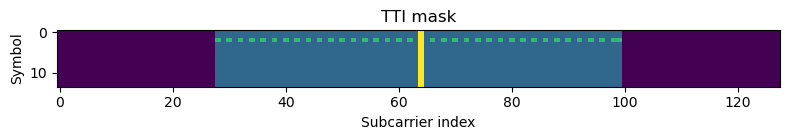

In [33]:
#S=14 symbols, first 28 all zero, last 28 all zero, mid F=72 all 1, Sp=2 (2,1,3), yellow bar =3
TTI_mask_RE = TTI_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset, plotTTI=True)

## Creating and Inserting Pilot Symbols in OFDM

Pilot symbols are crucial in OFDM systems for reliable data transmission, aiding in channel estimation, synchronization, and error correction at the receiver. They are predefined, known symbols placed at specific intervals across the OFDM frame. Their known properties help the receiver in demodulating and decoding the received signal accurately.

In [35]:
pilot_values = torch.tensor([-0.7 - 0.7j, -0.7 + 0.7j, 0.7 - 0.7j, 0.7 + 0.7j])

In [37]:
pilot_values.shape

torch.Size([4])

In [42]:
num_pilots = TTI_mask_RE[TTI_mask_RE == 2].numel() 

In [43]:
num_pilots

36

In [44]:
num_pilots//4+1

10

In [54]:
test=pilot_values.repeat(10)[:36] #https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html

In [55]:
test.shape

torch.Size([36])

In [50]:
pilot_values2=pilot_values.repeat(10) #4*10=40
pilot_values2.shape

torch.Size([40])

In [51]:
def pilot_set(TTI_mask, power_scaling=1.0):

    # Define QPSK pilot values, size of 4
    pilot_values = torch.tensor([-0.7 - 0.7j, -0.7 + 0.7j, 0.7 - 0.7j, 0.7 + 0.7j]) * power_scaling

    # Count the number of pilot elements in the TTI mask, Pilot symbols is 2
    num_pilots = TTI_mask[TTI_mask == 2].numel() #36

    # Create a list of pilot values repeated to match the number of pilots
    pilots = pilot_values.repeat(num_pilots//4+1)[:num_pilots] #4 number repeat 10 times=40, select 36 of them

    return pilots


In [34]:
TTI_mask_RE.shape

torch.Size([14, 128])

In [52]:
pilot_symbols = pilot_set(TTI_mask_RE, Pilot_Power)

In [53]:
pilot_symbols.shape

torch.Size([36])

In [57]:
pilot_symbols

tensor([-0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j,
        -0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j,
        -0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j,
        -0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j,
        -0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j,
        -0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j,
        -0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j,
        -0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j,
        -0.7000-0.7000j, -0.7000+0.7000j,  0.7000-0.7000j,  0.7000+0.7000j])

## Data stream creation OFDM Modulation, FFT, and Cyclic Prefix Addition

In [60]:
len(mapping_table_Qm)

64

In [62]:
TTI_mask_RE.shape

torch.Size([14, 128])

In [64]:
TTI_mask_RE.eq(1).sum()

tensor(958)

In [66]:
72*14

1008

In [67]:
#TTI_mask: [14, 128]
#Qm = 6  # bits per symbol
#mapping_table_Qm  64 len dict
def create_PDSCH_data(TTI_mask, Qm, mapping_table, power=1.):
    # Count PDSCH elements =1
    pdsch_elems = TTI_mask.eq(1).sum() #958
    
    # Generate random bits
    bits = torch.randint(0, 2, (pdsch_elems, Qm), dtype=torch.float32) #(958,6)

    # Flatten and reshape bits for symbol lookup
    flattened_bits = bits.reshape(-1, Qm)
   
    # Convert bits to tuples and lookup symbols
    symbs_list = [mapping_table[tuple(row.tolist())] for row in flattened_bits]
    symbs = torch.tensor(symbs_list, dtype=torch.complex64)

    # Reshape symbols back to original shape
    symbs = symbs.view(pdsch_elems, -1) #958
    symbs = symbs.flatten()
    
    # Apply power scaling 
    symbs *= power
    
    return bits, symbs

In [68]:
pdsch_bits, pdsch_symbols = create_PDSCH_data(TTI_mask_RE, Qm, mapping_table_Qm, power=PDSCH_power) # create PDSCH da

In [69]:
pdsch_bits.shape

torch.Size([958, 6])

In [72]:
pdsch_bits[0] #6 bit

tensor([0., 1., 0., 1., 1., 1.])

In [70]:
pdsch_symbols.shape #complex symbol

torch.Size([958])

In [71]:
pdsch_symbols[0]

tensor(-0.4629+1.0801j)

In [74]:
#TTI_mask: [14, 128]
#pilot_set/pilot_symbols: 36 complex symbols
#pdsch_symbols 958 symbols
#allocate pilot and data symbols to TTI
def RE_mapping(TTI_mask, pilot_set, pdsch_symbols, plotTTI=False): 

    # Create a zero tensor for the overall F (72) subcarriers * S symbols (S = 14 Number of symbols)
    TTI = torch.zeros(TTI_mask.shape, dtype=torch.complex64) #14,128

    # Allocate the payload and pilot
    TTI[TTI_mask==1] = pdsch_symbols.clone().detach()
    TTI[TTI_mask==2] = pilot_set.clone().detach()
    # Plotting the TTI modulated symbols
    if plotTTI:
        plt.figure(figsize=(8, 1.5))
        plt.imshow(torch.abs(TTI).numpy(), aspect='auto')  # Convert tensor to NumPy array for plotting
        plt.title('TTI modulated symbols')
        plt.xlabel('Subcarrier index')
        plt.ylabel('Symbol')
        if save_plots:
            plt.savefig('TTImod.png')
        plt.show()

    return TTI

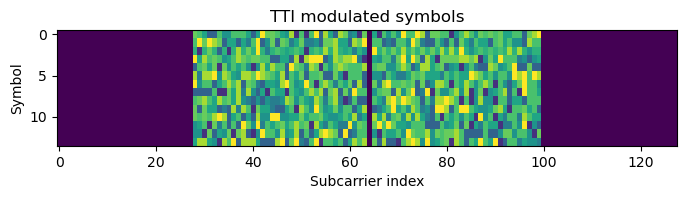

In [75]:
Modulated_TTI = RE_mapping(TTI_mask_RE, pilot_symbols, pdsch_symbols, plotTTI=True) # map the PDSCH and pilot symbols to the TTI

In [76]:
Modulated_TTI.shape

torch.Size([14, 128])

In [77]:
def FFT(TTI):
    return torch.fft.ifft(torch.fft.ifftshift(TTI, dim=1))

In [78]:
TD_TTI_IQ = FFT(Modulated_TTI) # perform the FFT

In [79]:
TD_TTI_IQ.shape

torch.Size([14, 128])

In [80]:
testiq=TD_TTI_IQ[0, -20:]
testiq.shape

torch.Size([20])

In [81]:
testiq2=TD_TTI_IQ[0,:]
testiq2.shape

torch.Size([128])

In [83]:
testiqall=torch.cat((testiq, testiq2), dim=0)

In [84]:
testiqall.shape

torch.Size([148])

In [85]:
#OFDM_data/TD_TTI_IQ: (14, 128)
#S = 14 Number of symbols
#FFT_size = 128
#CP:20
def CP_addition(OFDM_data, S, FFT_size, CP):

    # Initialize output tensor
    out = torch.zeros((S, FFT_size + CP), dtype=torch.complex64) #(14, 148)

    # Add cyclic prefix to each symbol
    #flip the CP(20) symbols and add in front of the 128 symbols
    for symbol in range(S): #14
        out[symbol, :] = torch.cat((OFDM_data[symbol, -CP:], OFDM_data[symbol, :]), dim=0)

    return out.flatten()


In [86]:
TX_Samples = CP_addition(TD_TTI_IQ, S, FFT_size, CP) # add the CP

In [88]:
14*148

2072

In [87]:
TX_Samples.shape

torch.Size([2072])

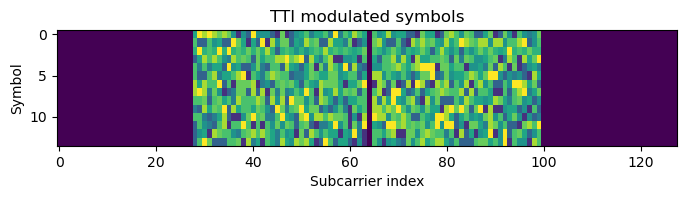

In [89]:
use_sdr = False
#leading_zeros (int): Number of symbols with zero value used for SINR measurement
leading_zeros = 80  # Number of symbols with zero value for noise measurement at the beginning of the transmission. Used for SINR estimation.

def create_OFDM_data():
    pdsch_bits, pdsch_symbols = create_PDSCH_data(TTI_mask_RE, Qm, mapping_table_Qm, power=PDSCH_power) # create PDSCH data and modulate it
    Modulated_TTI = RE_mapping(TTI_mask_RE, pilot_symbols, pdsch_symbols, plotTTI=True) # map the PDSCH and pilot symbols to the TTI
    TD_TTI_IQ = FFT(Modulated_TTI) # perform the FFT
    TX_Samples = CP_addition(TD_TTI_IQ, S, FFT_size, CP) # add the CP
    if use_sdr:
        zeros = torch.zeros(leading_zeros, dtype=TX_Samples.dtype) # create leading zeros for estimating noise floor power
        TX_Samples = torch.cat((zeros, TX_Samples), dim=0) # add leading zeros to TX samples
    return pdsch_bits, TX_Samples

pdsch_bits, TX_Samples = create_OFDM_data()

In [90]:
pdsch_bits.shape #958 is the total numbers of 1s in the mask, 6 is the Qm = 6  # bits per symbol

torch.Size([958, 6])

In [91]:
TX_Samples.shape #14*148

torch.Size([2072])

## Radio Channel - Transmitting and Receiving OFDM Symbols with PlutoSDR or a simulated channel

In [ ]:
# start the SDR 
import SDR_Pluto
SDR_TX_Frequency = int(920e6)  # SDR TX frequency in Hz
tx_gain = 0  # Transmission gain in dB for SDR
rx_gain = 10  # Reception gain in dB for SDR
if use_sdr:
     SDR_1 = SDR_Pluto.SDR(SDR_TX_IP="ip:192.168.1.10", SDR_TX_FREQ=SDR_TX_Frequency, SDR_TX_GAIN=tx_gain, SDR_RX_GAIN = rx_gain, SDR_TX_SAMPLERATE=SampleRate, SDR_TX_BANDWIDTH=F*SCS*2)
     SDR_1.SDR_TX_start()
#     tx_gain = SDR_1.find_good_max_TX_gain_value(SDR_RX_GAIN=30, Max_SINR=35)

In [92]:
#signal/TX_Samples 2072 (14*148) complex
# channel simulation
n_taps = 2 
max_delay = 6 #samples

def apply_multipath_channel(signal, n_taps, max_delay, repeats=0, random_start=True, SINR_s=30, leading_zeros=500):
    # note that the output is max_delay longer than input, due to the delayed symbols of some of the taps

    h = torch.zeros(max_delay+1, dtype=torch.complex64) #7

    for _ in range(n_taps): #2
        delay = torch.randint(1, max_delay, (1,)).item()  # Avoid delay=0 for remaining taps
        magnitude = torch.abs(torch.randn(1)) * 0.5
        phase = torch.randn(1)
        complex_gain = magnitude * torch.exp(1j * phase)
        h[delay] = complex_gain

    h[0] = torch.complex(torch.randn(1), torch.randn(1))

    # Normalize the channel response
    h = h / torch.norm(h)

    # Convolve the signal with the channel
    #https://pytorch.org/docs/stable/generated/torch.nn.functional.conv1d.html
    convolved_signal = torch.nn.functional.conv1d(signal.unsqueeze(0).unsqueeze(0), 
                                               h.unsqueeze(0).unsqueeze(0), 
                                               padding=max_delay).squeeze()
    
    # add leading zeros
    zeros = torch.zeros(leading_zeros, dtype=convolved_signal.dtype)
    convolved_signal = torch.cat((zeros, convolved_signal), dim=0)

    # Add noise based on SINR
    if SINR_s !=0:
        signal_power = torch.mean(torch.abs(convolved_signal)**2)
        noise_power = signal_power / (10 ** (SINR_s / 10))
        noise = torch.sqrt(noise_power / 2) * (torch.randn_like(convolved_signal) + 1j * torch.randn_like(convolved_signal))
        convolved_signal = convolved_signal + noise

    # Add random start if required
    if random_start:
        start_index = torch.randint(0, len(convolved_signal), (1,)).item()
        convolved_signal = torch.roll(convolved_signal, shifts=start_index)    
    
    # Repeat the signal if required
    if repeats > 0:
        convolved_signal = convolved_signal.repeat(repeats)

    return convolved_signal

In [94]:
#ch_SINR (int): Signal-to-Interference-plus-Noise Ratio (SINR) for the CDL-C channel emulation
# 3GPP CDL-C Channel Simulation Parameters in case no sdr
ch_SINR = 40  # SINR for channel emulation CDL-C
def radio_channel(use_sdr, tx_signal, tx_gain, rx_gain, ch_SINR):
    if use_sdr:
        SDR_1.SDR_gain_set(tx_gain, rx_gain) # set the gains
        SDR_1.SDR_TX_send(SAMPLES=tx_signal, max_scale=1, cyclic=True) # start transmitting the symbols in cyclic mode
        rx_signal = SDR_1.SDR_RX_receive(len(tx_signal)*4) # receive the signal
        SDR_1.SDR_TX_stop() # stop the transmission
    else:
        rx_signal = apply_multipath_channel(tx_signal, n_taps=n_taps, max_delay=max_delay, random_start=True, repeats=3, SINR_s=ch_SINR, leading_zeros=leading_zeros)
    return rx_signal

In [96]:
tx_gain = 0  # Transmission gain in dB for SDR
rx_gain = 10  # Reception gain in dB for SDR
RX_Samples = radio_channel(use_sdr=use_sdr, tx_signal = TX_Samples, tx_gain = tx_gain, rx_gain = rx_gain, ch_SINR=ch_SINR) 

In [98]:
TX_Samples.shape

torch.Size([2072])

In [97]:
RX_Samples.shape

torch.Size([6474])

## Power Spectral Densities of transmitted and received signals

In [99]:
def PSD_plot(signal, Fs, f, info='TX'):

    # Convert PyTorch tensor to NumPy array if necessary
    if isinstance(signal, torch.Tensor):
        signal = signal.numpy()

    plt.figure(figsize=(8, 3))
    plt.psd(signal, Fs=Fs, NFFT=1024, Fc=f, color='blue')
    plt.grid(True)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [dB/Hz]')
    plt.title(f'Power Spectral Density, {info}')
    if save_plots:
        plt.savefig(f'PSD_{info}.png')
    plt.show()

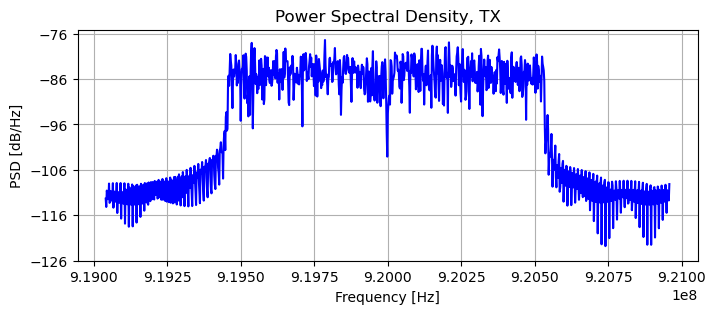

In [101]:
SDR_TX_Frequency = int(920e6)  # SDR TX frequency in Hz
PSD_plot(TX_Samples, SampleRate, SDR_TX_Frequency, 'TX')

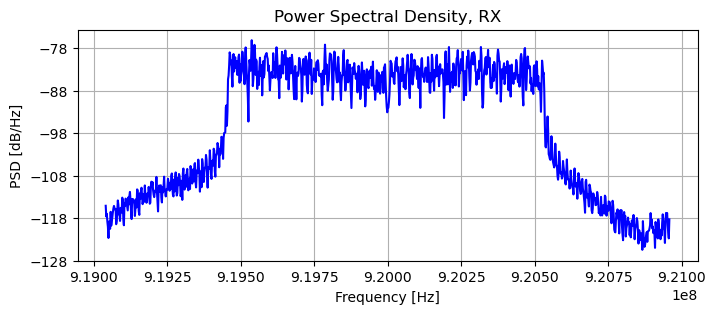

In [102]:
PSD_plot(RX_Samples, SampleRate, SDR_TX_Frequency, 'RX')

## Synchronization with Correlation for TTI Detection

Synchronization is achieved through correlation. The beginning of a Transmission Time Interval (TTI) us selected based on the first value exceeding an adjustable threshold. Cyclic prefix covers ISI for CP symbols from that point onwards.

In [136]:
import torch.nn.functional as tFunc
def sync_TTI(tx_signal, rx_signal, leading_zeros, threshold=6, plot=False):

    # time sync using correlation

    tx_len = tx_signal.numel()
    rx_len = rx_signal.numel()
    end_point=rx_len-tx_len

    rx_signal = rx_signal[leading_zeros:end_point]

    # Calculate the cross-correlation using conv1d
    corr_result_real = tFunc.conv1d(rx_signal.real.view(1, 1, -1), tx_signal.real.view(1, 1, -1)).view(-1)
    corr_result_imag = tFunc.conv1d(rx_signal.imag.view(1, 1, -1), tx_signal.imag.view(1, 1, -1)).view(-1)
    correlation =  torch.complex(corr_result_real, corr_result_imag)
    correlation = correlation.abs()
    threshold = correlation.mean()*threshold

    # Find the first peak that exceeds the threshold
    for i, value in enumerate(correlation):
        if value > threshold:
            if plot:
                plt.figure(figsize=(8, 4))
                plt.plot(correlation.abs()[i-10:i+50]) #only select -10~50 space
                plt.grid()
                plt.xlabel("Samples from selected index")
                plt.ylabel("Complex conjugate correlation")
                plt.axvline(x=10, color = 'r', linewidth=3)
                if save_plots:
                    plt.savefig('corr.png')
                plt.show()

            return i + leading_zeros
        
    i = torch.argmax(correlation).item() + leading_zeros

    return i

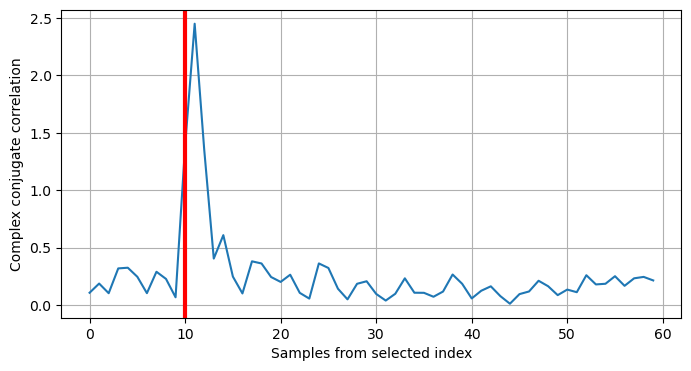

In [108]:
symbol_index=sync_TTI(TX_Samples, RX_Samples, leading_zeros=leading_zeros, threshold= 6, plot=True)

if use_sdr:
    symbol_index = symbol_index + leading_zeros

In [120]:
symbol_index

1149

In [121]:
leading_zeros

80

## SINR calculation

Null symbols were added into the beginning of each transmission to allow measuring the noise level at the receiver. The average power of transmitted symbols is divided by the average power of those null symbols. Note that this gives only a rough estimate, as in this simple implementation the null symbols outside the transmit bandwidth are included in transmitted power calculation.

In [109]:
def SINR(rx_signal, index, leading_zeros):
    # Calculate noise power

    rx_noise_0 = rx_signal[index - leading_zeros + 20 : index - 20]
    rx_noise_power_0 = torch.mean(torch.abs(rx_noise_0) ** 2)

    # Calculate signal power
    rx_signal_0 = rx_signal[index:index + (14 * 72)]
    rx_signal_power_0 = torch.mean(torch.abs(rx_signal_0) ** 2)

    # Compute SINR
    SINR = 10 * torch.log10(rx_signal_power_0 / rx_noise_power_0)

    # Round the SINR value
    SINR = round(SINR.item(), 1)

    return SINR, rx_noise_power_0, rx_signal_power_0

In [110]:
SINR_m, noise_power, signal_power = SINR(RX_Samples, symbol_index, leading_zeros) # calculate the SINR

In [113]:
signal_power

tensor(0.0055)

In [112]:
noise_power

tensor(5.4628e-07)

In [111]:
SINR_m

40.0

## Cyclic Prefix Removal

The cyclic prefix (CP) is added to each symbol to mitigate inter-symbol interference caused by multipath propagation. Once the signal is received, the CP must be removed to proceed with demodulation and data recovery.

In [118]:
RX_Samples.shape

torch.Size([6474])

In [119]:
symbol_index

1149

In [122]:
S

14

In [116]:
#rx_signal/RX_Samples 6474
#TTI_start/symbol_index 1149
#S=14 Number of symbols
def CP_removal(rx_signal, TTI_start, S, FFT_size, CP, plotsig=False):

    # Initialize a payload mask
    b_payload = torch.zeros(len(rx_signal), dtype=torch.bool)

    # Mark the payload parts of the signal
    for s in range(S):
        start_idx = TTI_start + (s + 1) * CP + s * FFT_size
        end_idx = start_idx + FFT_size
        b_payload[start_idx:end_idx] = 1

    # Plotting the received signal and payload mask
    if plotsig:
        # Assuming rx_signal is a PyTorch tensor
        # Convert to NumPy array and ensure it's in a float format to avoid overflow
        rx_signal_numpy = rx_signal.cpu().numpy()  # Use .cpu() if rx_signal is on GPU
        rx_signal_normalized = rx_signal_numpy / np.max(np.abs(rx_signal_numpy))

        plt.figure(0, figsize=(8, 4))
        plt.plot(rx_signal_normalized)
        plt.plot(b_payload, label='Payload Mask')
        plt.xlabel('Sample index')
        plt.ylabel('Amplitude')
        plt.title('Received signal and payload mask')
        plt.legend()
        if save_plots:
            plt.savefig('RXsignal_sync.png')
        plt.show()

    # Remove the cyclic prefix
    rx_signal_no_CP = rx_signal[b_payload]

    return rx_signal_no_CP.view(S, FFT_size)


/Users/kaikailiu/miniconda3/envs/mypy310/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


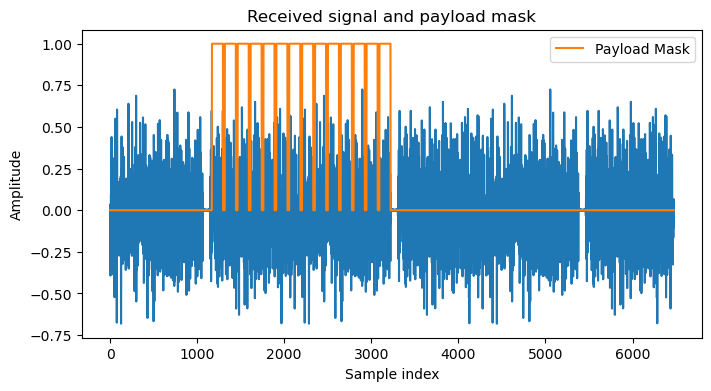

In [117]:
RX_NO_CP = CP_removal(RX_Samples, symbol_index, S, FFT_size, CP, plotsig=True) # remove the cyclic prefix
RX_NO_CP = RX_NO_CP / torch.max(torch.abs(RX_NO_CP)) # normalize the signal

In [124]:
RX_NO_CP.shape

torch.Size([14, 128])

## Convert the the time domain OFDM signal into frequency domain

Fast Fourier Transform (FFT) transforms the received time-domain signal back into the frequency domain, where data on individual subcarriers can be independently demodulated.

In [127]:
def DFT(rxsignal, plotDFT=False):

    # Calculate DFT
    OFDM_RX_DFT = torch.fft.fftshift(torch.fft.fft(rxsignal, dim=1), dim=1)

    # Plot the DFT if required
    if plotDFT:
        plt.figure(figsize=(8, 1.5))
        plt.imshow(torch.abs(OFDM_RX_DFT).numpy(), aspect='auto')  # Convert tensor to NumPy array for plotting
        plt.xlabel('Subcarrier Index')
        plt.ylabel('Symbol')
        if save_plots:
            plt.savefig('TTI_RX.png')
        plt.show()

    return OFDM_RX_DFT

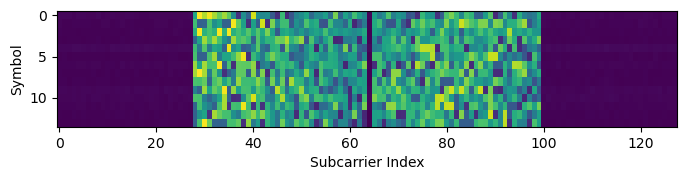

In [128]:
OFDM_demod = DFT(RX_NO_CP, plotDFT=True) # perform the DFT on the received signal and plot the result

In [129]:
OFDM_demod.shape

torch.Size([14, 128])

## Channel Estimation

Channel estimation aims to characterize the channel's effect on the transmitted signal, which is essential for accurate data demodulation and improving system performance.

In [130]:
def torch_interp(x, xp, fp):
    # Ensure xp and fp are sorted
    sorted_indices = torch.argsort(xp)
    xp = xp[sorted_indices].to(device=x.device)
    fp = fp[sorted_indices].to(device=x.device)

    # Find the indices to the left and right of x
    indices_left = torch.searchsorted(xp, x, right=True)
    indices_left = torch.clamp(indices_left, 0, len(xp) - 1)

    indices_right = torch.clamp(indices_left - 1, 0, len(xp) - 1)

    # Perform linear interpolation
    x_left, x_right = xp[indices_left], xp[indices_right]
    f_left, f_right = fp[indices_left], fp[indices_right]
    interp_values = f_left + (f_right - f_left) * (x - x_left) / (x_right - x_left)

    return interp_values

In [134]:
FFT_offset

28

In [138]:
F # Number of subcarriers, including DC

72

In [139]:
def channelEstimate_LS(TTI_mask_RE, pilot_symbols, F, FFT_offset, Sp, OFDM_demod, plotEst=False):
    # Pilot extraction
    pilots = OFDM_demod[TTI_mask_RE == 2]

    # Divide the pilots by the set pilot values
    H_estim_at_pilots = pilots / pilot_symbols

    # Interpolation indices
    pilot_indices = torch.nonzero(TTI_mask_RE[Sp] == 2, as_tuple=False).squeeze()

    # Interpolation for magnitude and phase
    all_indices = torch.arange(FFT_offset, FFT_offset + F)
    
    # Linear interpolation for magnitude and phase
    H_estim_abs = torch_interp(all_indices, pilot_indices, torch.abs(H_estim_at_pilots))
    H_estim_phase = torch_interp(all_indices, pilot_indices, torch.angle(H_estim_at_pilots))

    # Convert magnitude and phase to complex numbers
    H_estim_real = H_estim_abs * torch.exp(1j * H_estim_phase).real
    H_estim_imag = H_estim_abs * torch.exp(1j * H_estim_phase).imag

    # Combine real and imaginary parts to form complex numbers
    H_estim = torch.view_as_complex(torch.stack([H_estim_real, H_estim_imag], dim=-1))


    def dB(x):
        return 10 * torch.log10(torch.abs(x))

    if plotEst:
        plt.figure(figsize=(8, 4))
        plt.plot(pilot_indices.cpu().numpy(), dB(H_estim_at_pilots).cpu().numpy(), 'ro-', label='Pilot estimates', markersize=8)
        plt.plot(all_indices.cpu().numpy(), dB(torch.tensor(H_estim)).cpu().numpy(), 'b-', label='Estimated channel', linewidth=2)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.xlabel('Subcarrier Index', fontsize=12)
        plt.ylabel('Magnitude (dB)', fontsize=12)
        plt.legend(loc='upper right', fontsize=10)
        plt.title('Pilot Estimates and Interpolated Channel in dB', fontsize=14)
        if save_plots:
            plt.savefig('ChannelEstimate.png')
        plt.show()

    return H_estim

/var/folders/ns/y1vh84yx69b02kfct_lnh3yh0000gn/T/ipykernel_10567/1550191228.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(all_indices.cpu().numpy(), dB(torch.tensor(H_estim)).cpu().numpy(), 'b-', label='Estimated channel', linewidth=2)


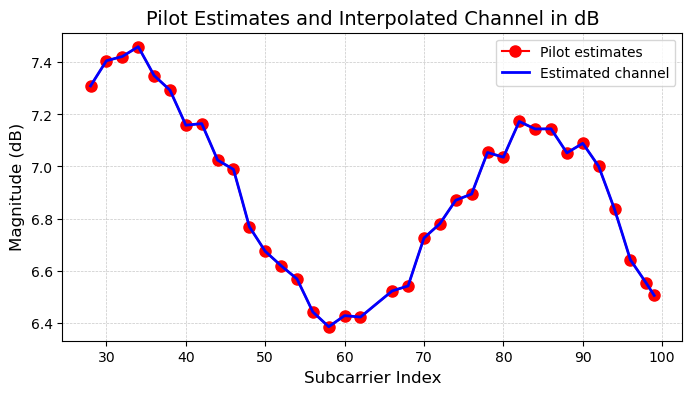

In [140]:
H_estim = channelEstimate_LS(TTI_mask_RE, pilot_symbols, F, FFT_offset, Sp, OFDM_demod, plotEst=True) # estimate the channel using least squares and plot

## Equalization in OFDM Systems

Equalization aims to mitigate the phase and amplitude variations introduced by the communication channel, ensuring accurate data recovery.

In [141]:
def remove_fft_Offests(RX_NO_CP, F, FFT_offset):

    # Calculate indices for the remaining subcarriers after removing offsets
    remaining_indices = torch.arange(FFT_offset, F + FFT_offset)

    # Remove the FFT offsets using slicing
    OFDM_demod = RX_NO_CP[:, remaining_indices]

    return OFDM_demod

In [142]:
OFDM_demod_no_offsets = remove_fft_Offests(OFDM_demod, F, FFT_offset) # remove the FFT offsets and DC carrier from the received signal

In [143]:
OFDM_demod_no_offsets.shape

torch.Size([14, 72])

In [144]:
def equalize_ZF(OFDM_demod, H_estim, F, S):

    # Reshape the OFDM data and perform equalization
    equalized = (OFDM_demod.view(S, F) / H_estim.to(device=OFDM_demod.device))
    return equalized

In [145]:
equalized_H_estim = equalize_ZF(OFDM_demod_no_offsets, H_estim, F, S) # equalize the channel using ZF

In [146]:
equalized_H_estim.shape

torch.Size([14, 72])

## Payload Symbols extraction

The payload in an OFDM system refers to the actual data transmitted, excluding overheads like cyclic prefixes, pilot symbols, and any additional signaling or control information.

In [147]:
def get_payload_symbols(TTI_mask_RE, equalized, FFT_offset, F, plotQAM=False):
    # Extract payload symbols
    mask = TTI_mask_RE[:, FFT_offset:FFT_offset + F] == 1
    out = equalized[mask]

    # Plotting the QAM symbols
    if plotQAM:
        plt.figure(figsize=(8, 8))
        plt.scatter(out.cpu().real, out.cpu().imag, label='QAM Symbols')
        plt.axis('equal')
        plt.xlim([-1.5, 1.5])
        plt.ylim([-1.5, 1.5])
        plt.xlabel('Real Part', fontsize=12)
        plt.ylabel('Imaginary Part', fontsize=12)
        plt.title('Received QAM Constellation Diagram', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(loc='upper right', fontsize=10)
        if save_plots:
            plt.savefig('RXdSymbols.png')
        plt.show()
    return out

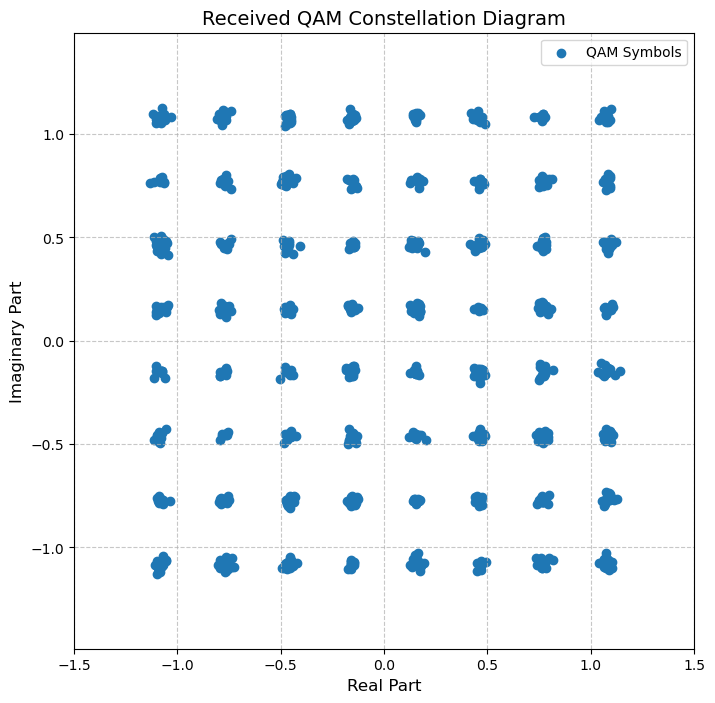

In [148]:
QAM_est = get_payload_symbols(TTI_mask_RE, equalized_H_estim, FFT_offset, F, plotQAM=True) # get the payload symbols from

In [149]:
QAM_est.shape

torch.Size([958])

## Converting OFDM Symbols to Data

After receiving and processing the OFDM symbols, the final step is to convert them back into the original data stream. This process involves demodulation, demapping and combining the information to data stream.

In [150]:
def Demapping(QAM, de_mapping_table):
    # Convert the demapping table keys (constellation points) to a tensor
    constellation = torch.tensor(list(de_mapping_table.keys())).to(QAM.device)
    dists = torch.abs(QAM.view(-1, 1) - constellation.view(1, -1))
    const_index = torch.argmin(dists, dim=1).to(QAM.device)
    hardDecision = constellation[const_index].to(QAM.device)
    string_key_table = {str(key.item()): value for key, value in de_mapping_table.items()}
    demapped_symbols = torch.tensor([string_key_table[str(c.item())] for c in hardDecision], dtype=torch.int32)
    return demapped_symbols, hardDecision


In [151]:
PS_est, hardDecision = Demapping(QAM_est, de_mapping_table_Qm) # demap the symbols back to codewords

In [154]:
hardDecision.shape

torch.Size([958])

In [152]:
PS_est.shape

torch.Size([958, 6])

In [155]:
def PS(bits): # parallel to serial
    return bits.view(-1)

In [156]:
bits_est = PS(PS_est) # convert the codewords to the bitstream
print(bits_est)

tensor([0, 0, 1,  ..., 1, 0, 0], dtype=torch.int32)


In [157]:
bits_est.shape

torch.Size([5748])

## Calculating Bit Error Rate (BER)

In [158]:
error_count = torch.sum(bits_est != pdsch_bits.flatten()).float()  # Count of unequal bits
error_rate = error_count / bits_est.numel()  # Error rate calculation
BER = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places
SINR_m = SINR(RX_Samples, symbol_index, leading_zeros=leading_zeros)[0] # calculate the SINR
print(f"BER: {BER}, SINR: {SINR_m}dB") # print the BER and SINR

BER: 0.0, SINR: 40.0dB


## Visualize bit errors

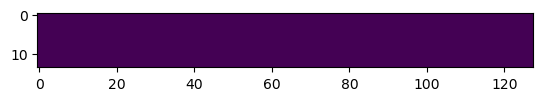

In [159]:
# Create a zero tensor for the overall F subcarriers * S symbols
TTI_t = np.zeros(TTI_mask_RE.shape)

# Allocate the payload and pilot
errors = (bits_est != pdsch_bits.flatten()).reshape(-1, 6).sum(axis=1)

TTI_t[TTI_mask_RE==1] = errors


plt.imshow(TTI_t)